# 🔦 Clasificación de Planes Móviles: Recomendación Inteligente entre Smart y Ultra para Megaline

📝 Megaline, una compañía de telecomunicaciones, ha lanzado dos nuevos planes móviles: Smart y Ultra. Sin embargo, una parte considerable de sus clientes continúa utilizando planes antiguos. Para optimizar la transición y ofrecer a cada cliente la mejor opción, se busca desarrollar un modelo de clasificación que, a partir del comportamiento mensual de uso (llamadas, minutos, mensajes y datos), prediga qué plan es más adecuado para cada usuario.

🎯 Este proyecto aplica algoritmos de aprendizaje automático supervisado para construir y comparar distintos modelos clasificadores. El objetivo principal es alcanzar una exactitud mínima del 75% en las predicciones. Para ello, se entrenarán modelos con diferentes hiperparámetros y se evaluará su rendimiento utilizando técnicas de validación cruzada, así como conjuntos de datos de prueba independientes.

## 🧹 Preparación de datos

In [1]:
# Cargar libreria
import pandas as pd

# Cargar los datos
df = pd.read_csv('/datasets/users_behavior.csv')

# Vista general
display(df.head())

# Información general 
print(df.info())

# Estadísticas descriptivas
print(df.describe())


,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB
None
             calls      minutes     messages       mb_used     is_ultra
count  3214.000000  3214.000000  3214.000000   3214.000000  3214.000000
mean     63.038892   438.208787    38.281269  17207.673836     0.306472
std      33.236368   234.569872    36.148326   7570.968246     0.461100
min       0.000000     0.000000     0.000000      0.000000     0.000000
25%      40.000000   274.575000     9.000000  12491.902500     0.000000
50%      62.000000   430.600000    30.000000  16943.235000     0.000000
75%      82.000000   571.927500    57.000000  21424.700000  

### 🔍 Análisis Exploratorio Inicial
Después de cargar los datos, se realiza una inspección general para conocer la estructura y distribución de las variables.

**✅ Información general:**
El dataset contiene 3,214 registros y 5 columnas.

No hay valores nulos, ya que todas las columnas tienen la misma cantidad de datos (non-null = 3214).

Las variables calls, minutes, messages y mb_used son de tipo float64 (numéricas continuas).

La variable objetivo is_ultra es de tipo entero (int64) y representa un valor binario:

0: Plan Smart

1: Plan Ultra

**📊 Estadísticas descriptivas por variable:**

- `calls`  El número de llamadas varía de 0 a 244, con un promedio de \~63 llamadas. Algunos usuarios no hicieron llamadas.  
- `minutes`  La duración total de llamadas varía desde 0 hasta 1632 minutos. El promedio es de \~438 minutos.
-  `messages` El número de SMS enviados tiene una media de \~38 pero puede llegar a 224. Hay usuarios que no enviaron mensajes.
-  `mb_used`  El consumo de internet es muy variable, con un promedio de \~17,200 MB (17.2 GB), y llega hasta casi 50 GB.
-  `is_ultra` Solo el **30.6%** de los registros pertenecen al plan Ultra. Es decir, la clase está **desequilibrada**. 

**📌 Posibles implicaciones:**
Dado que hay clientes que no usaron llamadas, mensajes o datos, será importante revisar si eso afecta la predicción.

**Conclusión:**
Por ahora, se puede determinar que los datos están limpios y listos para ser divididos en entrenamiento, validación y prueba.

## ✂️ Dividir el conjunto de datos

Se separarán los datos en:

Conjunto de entrenamiento (60%)

Conjunto de validación (20%)

Conjunto de prueba (20%)

In [2]:
# Libreria
from sklearn.model_selection import train_test_split

# Se separan las características (variables predictoras) del objetivo
features = df.drop('is_ultra', axis=1)
target = df['is_ultra']

# Dividir en 60% train y 40% temporal (que será luego valid/test)
features_train, features_temp, target_train, target_temp = train_test_split(features, target, test_size=0.4, random_state=12345)

# De la parte temporal (40%), se divide en 50/50 → 20% valid y 20% test
features_valid, features_test, target_valid, target_test = train_test_split(features_temp, target_temp, test_size=0.5, random_state=12345)

print(features_train.shape, features_valid.shape, features_test.shape)


(1928, 4) (643, 4) (643, 4)


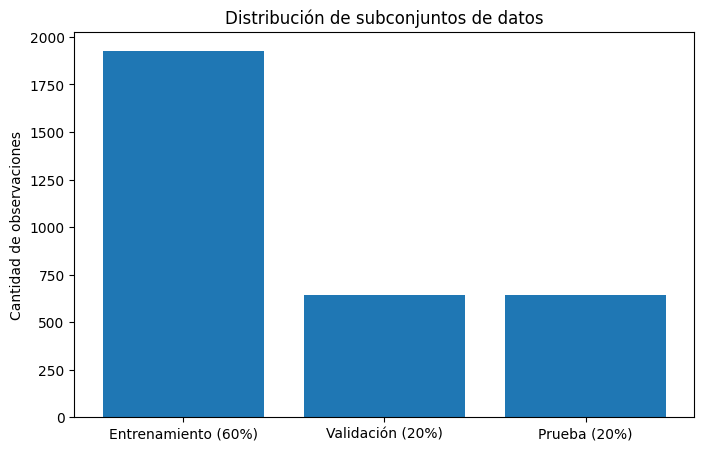

In [3]:
# Libreria para graficar
import matplotlib.pyplot as plt

# Valores de tamaños
sizes = [features_train.shape[0], features_valid.shape[0], features_test.shape[0]]
labels = ['Entrenamiento (60%)', 'Validación (20%)', 'Prueba (20%)']

# Crear gráfico de barras
plt.figure(figsize=(8, 5))
plt.bar(labels, sizes)
plt.title('Distribución de subconjuntos de datos')
plt.ylabel('Cantidad de observaciones')
plt.show()

## 🧪 Paso 3: Entrenamiento y comparación de modelos

**🔍 Objetivo:**
Desarrollar modelos de clasificación que predigan si un cliente debería usar el plan Smart (0) o Ultra (1). Evaluaremos varios modelos y sus hiperparámetros usando el conjunto de validación.

### 📌 Entrenamiento de un Árbol de Decisión

In [4]:
# Librerias necesarias para el entrenamiento de un arbol de decisión 
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Se crean variables
best_dt_model = None
best_dt_score = 0
best_dt_depth = 0

for depth in range(1, 11):
    dt_model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    dt_model.fit(features_train, target_train)
    predictions = dt_model.predict(features_valid)
    acc = accuracy_score(target_valid, predictions)
    display(f'Depth: {depth} - Accuracy: {acc:.4f}')
    
    if acc > best_dt_score:
        best_dt_score = acc
        best_dt_model = dt_model
        best_dt_depth = depth

'Depth: 1 - Accuracy: 0.7543'

'Depth: 2 - Accuracy: 0.7823'

'Depth: 3 - Accuracy: 0.7854'

'Depth: 4 - Accuracy: 0.7792'

'Depth: 5 - Accuracy: 0.7792'

'Depth: 6 - Accuracy: 0.7838'

'Depth: 7 - Accuracy: 0.7823'

'Depth: 8 - Accuracy: 0.7792'

'Depth: 9 - Accuracy: 0.7823'

'Depth: 10 - Accuracy: 0.7745'

**📈 Resultados por profundidad (max_depth)**

- La mejor exactitud: **0.7854**, se obtuvo con **max_depth = 3**.
- A partir de depth = 3, la exactitud no mejora significativamente, e incluso empieza a bajar o mantenerse.
- Esto sugiere que a partir de cierto punto, el árbol podría estar sobreajustándose: se adapta mucho al conjunto de entrenamiento pero no mejora en datos nuevos.

Este modelo supera el umbral mínimo exigido por el proyecto, que era 0.75.

### 🌲 2. Bosque Aleatorio

In [5]:
# Libreria bosque aleatorio
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Se crean variables para guardar los mejores resultados
best_acc = 0
best_est = 0
best_depth = 0

# Probamos varias combinaciones de hiperparámetros
for est in range(10, 60, 10):  # est: número de árboles
    for depth in range(1, 11):  # depth: profundidad máxima de los árboles
        rf_model = RandomForestClassifier(
            n_estimators=est,
            max_depth=depth,
            random_state=12345
        )
        rf_model.fit(features_train, target_train)  # Se entrena el modelo
        predictions = rf_model.predict(features_valid)  # Predice sobre validación
        acc = accuracy_score(target_valid, predictions)  # Calcula exactitud
        print(f"Estimators: {est}, Depth: {depth} - Accuracy: {acc:.4f}")

        # Guardar el mejor resultado
        if acc > best_acc:
            best_acc = acc
            best_est = est
            best_depth = depth


Estimators: 10, Depth: 1 - Accuracy: 0.7558
Estimators: 10, Depth: 2 - Accuracy: 0.7776
Estimators: 10, Depth: 3 - Accuracy: 0.7854
Estimators: 10, Depth: 4 - Accuracy: 0.7900
Estimators: 10, Depth: 5 - Accuracy: 0.7932
Estimators: 10, Depth: 6 - Accuracy: 0.8009
Estimators: 10, Depth: 7 - Accuracy: 0.7947
Estimators: 10, Depth: 8 - Accuracy: 0.7963
Estimators: 10, Depth: 9 - Accuracy: 0.7854
Estimators: 10, Depth: 10 - Accuracy: 0.7916
Estimators: 20, Depth: 1 - Accuracy: 0.7667
Estimators: 20, Depth: 2 - Accuracy: 0.7838
Estimators: 20, Depth: 3 - Accuracy: 0.7869
Estimators: 20, Depth: 4 - Accuracy: 0.7885
Estimators: 20, Depth: 5 - Accuracy: 0.7900
Estimators: 20, Depth: 6 - Accuracy: 0.7994
Estimators: 20, Depth: 7 - Accuracy: 0.8009
Estimators: 20, Depth: 8 - Accuracy: 0.7978
Estimators: 20, Depth: 9 - Accuracy: 0.7900
Estimators: 20, Depth: 10 - Accuracy: 0.7916
Estimators: 30, Depth: 1 - Accuracy: 0.7667
Estimators: 30, Depth: 2 - Accuracy: 0.7838
Estimators: 30, Depth: 3 - Acc

**📝 Conclusión:**

- Con este modelo la mejor exactitud fue obtenida con **n_estimators=40** y **max_depth=8**, alcanzando una exactitud del **80.87%**, superando el umbral de 0.75 que se exige en el proyecto, lo cual indica que el modelo es aceptable para producción o implementación.

### 🧮 Entrenamiento de Regresión Logística

In [6]:
# Se carga libreria de Regresión Logística
from sklearn.linear_model import LogisticRegression

# Se crea el modelo liblinear 
lr_model = LogisticRegression(random_state=12345, solver='liblinear')

# Se entrena el modelo
lr_model.fit(features_train, target_train)

# Se hace predicciones sobre el conjunto de validación
predictions = lr_model.predict(features_valid)

# Se calcula y se imprime la exactitud
lr_score = accuracy_score(target_valid, predictions)
print(f'Logistic Regression Accuracy: {lr_score:.4f}')


Logistic Regression Accuracy: 0.7092


**📝 Conclusión:**
- El modelo acertó en **70.92%** de los casos al predecir correctamente si un usuario debe tener el plan Smart (0) o Ultra (1).

- Es un resultado razonable, pero está por debajo del umbral mínimo exigido de 75%, por lo tanto no es suficiente para cumplir el objetivo del proyecto.

## 📊 Comparación Final de Modelos

In [7]:
print(f'Mejor exactitud del Árbol de Decisión - Depth {best_dt_depth} - Accuracy: {best_dt_score:.4f}')
print(f"Mejor exactitud del Bosque Aleatorio - Estimators: {best_est}, Depth: {best_depth} - Accuracy: {best_acc:.4f}")
print(f'Mejor exactitud de la Regresión Logística - Accuracy: {lr_score:.4f}')

Mejor exactitud del Árbol de Decisión - Depth 3 - Accuracy: 0.7854
Mejor exactitud del Bosque Aleatorio - Estimators: 40, Depth: 8 - Accuracy: 0.8087
Mejor exactitud de la Regresión Logística - Accuracy: 0.7092


----------------------------------------------------------------------------------------------------------------
- **Árbol de Decisión**

  Exactitud (Accuracy): 0.7854 Buen rendimiento. Supera el umbral mínimo (0.75). Sencillo pero puede sobreajustarse si no se controla.
-----------------------------------------------------------------------------------------------------------------
- ✅ **Bosque Aleatorio**

  Exactitud (Accuracy): **0.8087**  🏆 **Mejor modelo**. Combina múltiples árboles, lo que reduce el sobreajuste y mejora la generalización.
-----------------------------------------------------------------------------------------------------------------
- **Regresión Logística**

  Exactitud (Accuracy): 0.7092 ❌ No alcanza el mínimo requerido. Modelo lineal, útil como referencia inicial.
-----------------------------------------------------------------------------------------------------------------

**📝 CONCLUSIÓN**

El modelo de ***Bosque Aleatorio*** con 40 estimadores y profundidad 8 es el mejor, con una exactitud de **0.8087**, superior al mínimo requerido de 0.75.

Será el modelo elegido para hacer la predicción final en el conjunto de prueba.

## 🔬 Paso 4: Evaluación del modelo con el conjunto de prueba

Entrenamos nuevamente el mejor modelo con los datos de entrenamiento + validación. Se utiliza el modelo ganador **Bosque aleatorio**

In [8]:
# Se llaman nuevamente las librerias del modelo ganador para claridad en el codigo
from sklearn.ensemble import RandomForestClassifier  
from sklearn.metrics import accuracy_score

# Unimos datos de entrenamiento y validación
features_trainval = pd.concat([features_train, features_valid])
target_trainval = pd.concat([target_train, target_valid])

# Entrenamos el mejor modelo (hiperparámetros ajustados al mejor resultado que se obtuvo)
final_model = RandomForestClassifier(n_estimators=40, max_depth=8, random_state=12345)
final_model.fit(features_trainval, target_trainval)

# Evaluamos con el conjunto de prueba
test_predictions = final_model.predict(features_test)
test_accuracy = accuracy_score(target_test, test_predictions)

print("✅ Exactitud del modelo final en el conjunto de prueba:", round(test_accuracy, 4))


✅ Exactitud del modelo final en el conjunto de prueba: 0.7994


### 🚩 Evaluación final del modelo
El mejor modelo, un Random Forest con `n_estimators = 40` y `max_depth = 8`, alcanzó una exactitud de **0.8087** en validación y **0.7994** en el conjunto de prueba. 

**Esto demuestra que el modelo generaliza bien a nuevos datos y es adecuado para recomendar planes Smart o Ultra.**


## 🧠 Paso 5: Prueba de cordura al modelo

🎯 Objetivo
Asegurarnos de que nuestro modelo no esté tomando decisiones aleatorias o triviales, y que realmente aprendió patrones útiles.

In [9]:
# Se utilizará DummyClassifier: un modelo muy simple que no aprende nada, solo predice de forma fija o aleatoria según la estrategia.
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

# Creamos un modelo dummy que hace predicciones al azar
dummy_model = DummyClassifier(strategy='most_frequent', random_state=12345) 
# strategy='most_frequent' significa que el modelo siempre va a predecir la clase que más aparece en los datos de entrenamiento 
dummy_model.fit(features_train, target_train)
# Se entrena, aunque en realidad no aprende, solo guarda cuál clase es la más común

# Hacemos predicciones. como usa most_frequent, todas las predicciones serán iguales (todo 0 o todo 1), según cuál clase es más frecuente.
dummy_predictions = dummy_model.predict(features_test)

# Calculamos la exactitud
dummy_accuracy = accuracy_score(target_test, dummy_predictions)
print("Exactitud del modelo dummy (prueba de cordura):", dummy_accuracy)


Exactitud del modelo dummy (prueba de cordura): 0.6842923794712286


### ✅ Resultados de la Prueba de Cordura

Tras entrenar y validar varios modelos, seleccionamos un modelo Random Forest con los mejores hiperparámetros.

Para comprobar su calidad real, lo evaluamos sobre el conjunto de prueba, y también lo comparamos contra un modelo dummy, el cual simplemente predice la clase más frecuente.

- **Random Forest (final):**
  Exactitud en conjunto de prueba =	**0.7994** ✅
- **Dummy Classifier**
  Exactitud en conjunto de prueba = **0.6843** ❌

*🔍 Conclusión: El modelo final supera significativamente al modelo dummy.*

**Esto indica que el modelo no está adivinando, sino que ha aprendido patrones relevantes en los datos y generaliza bien a nuevos usuarios.**


## 💡 Conclusión final:

El modelo Random Forest cumple con los requisitos del negocio y puede utilizarse como una herramienta para recomendar planes óptimos a los usuarios de Megaline con alta precisión, ya qué demostró ser el más eficaz entre las alternativas probadas (Árbol de Decisión y Regresión Logística), alcanzando una exactitud casi del 80% en el conjunto de prueba. Este rendimiento supera con creces tanto el umbral mínimo establecido por el negocio (75%) como el desempeño del modelo de referencia (dummy), lo que indica que el modelo no está adivinando, sino aprendiendo patrones significativos de los datos.

Dados estos resultados se puede decir que el modelo Random Forest es una excelente herramienta para recomendar de forma automatizada y precisa el plan más adecuado (Smart o Ultra) para cada usuario según su comportamiento mensual.

Además, su uso puede ayudar a reducir la dependencia de planes heredados, mejorar la experiencia del cliente y aumentar la eficiencia en la estrategia comercial de Megaline. Este modelo puede integrarse en sistemas de recomendación o análisis interno para apoyar decisiones de marketing y ventas personalizadas.